In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import os

# Visualizing 3D Data

In [72]:
def read_off(file_path):
    with open(file_path, 'r') as file:
        # Read the header
        header = file.readline().strip()
        if header != 'OFF':
            raise ValueError('Not a valid OFF file')

        # Read number of vertices, faces, and edges
        n_verts, n_faces, _ = map(int, file.readline().strip().split())

        # Read vertex coordinates
        vertices = []
        for _ in range(n_verts):
            vertex = list(map(float, file.readline().strip().split()))
            vertices.append(vertex)
        vertices = np.array(vertices)

        # Read faces (index of vertices)
        faces = []
        for _ in range(n_faces):
            face_info = list(map(int, file.readline().strip().split()))
            face = face_info[1:]  # Ignore the first number (number of vertices in the face)
            faces.append(face)
        faces = np.array(faces)

        # Center the model: subtract the centroid of the vertices
    centroid = np.mean(vertices, axis=0)
    vertices -= centroid

    # Normalize the size: scale vertices to fit within a unit sphere
    max_distance = np.max(np.linalg.norm(vertices, axis=1))
    vertices /= max_distance

    return vertices, faces


In [68]:
def visualize_model(vertices, faces):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Create a Poly3DCollection object
    mesh = Poly3DCollection(vertices[faces], alpha=0.5)
    
    # Add the collection to the axes
    ax.add_collection3d(mesh)

    # Set limits
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    
    # Auto scale to the mesh size
    scale = vertices.flatten()
    ax.auto_scale_xyz(scale, scale, scale)

    plt.show()

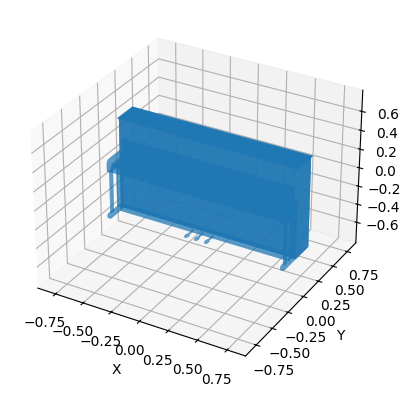

In [86]:
label = "piano"
n = "0020"
model = f"./ModelNet40/{label}/train/{label}_{n}.off"

vertices, faces = read_off(model)
visualize_model(vertices, faces)

# Visualizing 2D sketches

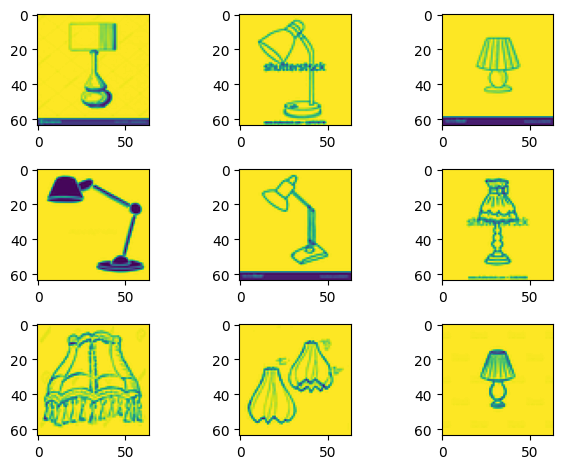

In [59]:
from PIL import Image

label = "lamp"

pth = f"ImageNetSketchMini/{label}/"
fls = os.listdir(pth)
s = 10

for i in range(s, s+9):
    im_pth = pth + fls[i]
    img = Image.open(im_pth)
    img = img.convert('L')
    img = img.resize((64, 64), Image.Resampling.LANCZOS)
    img = np.array(img)
    plt.subplot(3, 3, i-s+1)
    plt.imshow(img)

plt.tight_layout()
plt.show()

- Stairs
- Baththub
- Merge bed/sofa
- desk
- 

# Model to 3d Voxel Grid

In [82]:
from scipy.spatial import cKDTree

def read_off_to_voxels(file_path, grid_size=32):
    with open(file_path, 'r') as file:
        # Read the header
        header = file.readline().strip()
        if header != 'OFF':
            raise ValueError('Not a valid OFF file')

        # Read number of vertices, faces, and edges
        n_verts, n_faces, _ = map(int, file.readline().strip().split())

        # Read vertex coordinates
        vertices = []
        for _ in range(n_verts):
            vertex = list(map(float, file.readline().strip().split()))
            vertices.append(vertex)
        vertices = np.array(vertices)

        # Read faces (index of vertices)
        faces = []
        for _ in range(n_faces):
            face_info = list(map(int, file.readline().strip().split()))
            face = face_info[1:]  # Ignore the first number (number of vertices in the face)
            faces.append(face)
        faces = np.array(faces)

    # Center the model: subtract the centroid of the vertices
    centroid = np.mean(vertices, axis=0)
    vertices -= centroid

    # Normalize the size: scale vertices to fit within a unit sphere
    max_distance = np.max(np.linalg.norm(vertices, axis=1))
    vertices /= max_distance

    # Convert the 3D model to a voxel grid
    # Step 1: Scale the vertices to fit within the grid size
    scaled_vertices = (vertices + 1) * (grid_size - 1) / 2  # Scale to [0, grid_size - 1]
    scaled_vertices = scaled_vertices.astype(int)  # Convert to integers

    # Step 2: Create an empty voxel grid
    voxel_grid = np.zeros((grid_size, grid_size, grid_size), dtype=np.uint8)

    # Step 3: Fill the voxel grid based on the vertex positions
    # Using a KD-Tree to check proximity and fill neighboring voxels for "surface"
    tree = cKDTree(scaled_vertices)
    for vertex in scaled_vertices:
        voxel_grid[vertex[0], vertex[1], vertex[2]] = 1

    return voxel_grid


In [91]:
array3d = read_off_to_voxels(model, 32)
array3d.shape

(32, 32, 32)

In [84]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_voxel_grid(voxel_grid):
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Get the x, y, z coordinates of the non-zero (filled) voxels
    filled = np.argwhere(voxel_grid == 1)

    # Plot the filled voxels
    ax.scatter(filled[:, 0], filled[:, 1], filled[:, 2], zdir='z', c='red', marker='o')

    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')

    plt.show()


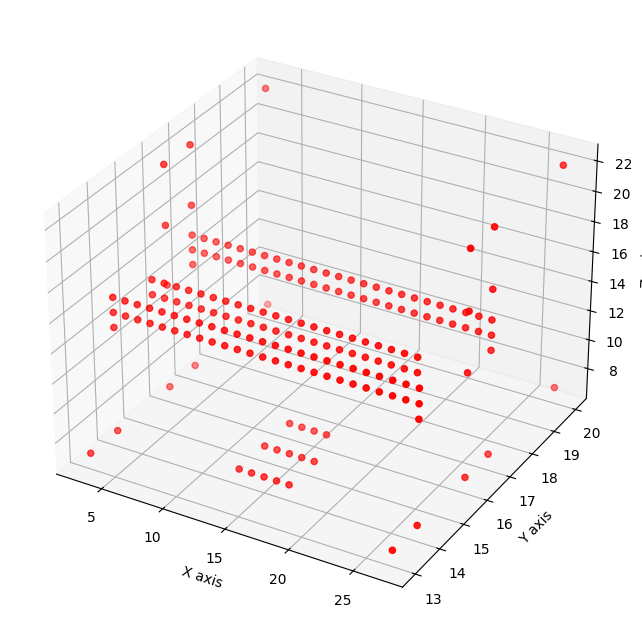

In [92]:
plot_voxel_grid(array3d)